# 2 - Data import, clean

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import minimize


### Reading monthly returns

Monthly figures, we have end-of-month data, not always prefectly aligned to the end of month

In [58]:
USD_monthly_returns = pd.read_csv('data/US_value_weighted_returns.csv', parse_dates=['date'], index_col='date')

japan       = pd.read_csv("data/JAPAN.csv",       parse_dates=["date"], index_col="date")[["mportret"]]
australia   = pd.read_csv("data/AUSTRALIA.csv",   parse_dates=["date"], index_col="date")[["mportret"]]
germany     = pd.read_csv("data/GERMANY.csv",     parse_dates=["date"], index_col="date")[["mportret"]]
france      = pd.read_csv("data/FRANCE.csv",      parse_dates=["date"], index_col="date")[["mportret"]]
switzerland = pd.read_csv("data/SWITZERLAND.csv", parse_dates=["date"], index_col="date")[["mportret"]]
unitedkingdom = pd.read_csv("data/UNITEDKINGDOM.csv", parse_dates=["date"], index_col="date")[["mportret"]]

switzerland.head()

,mportret
date,
2000-01-31,-0.072023
2000-02-29,-0.001949
2000-03-31,0.081995
2000-04-28,0.002559
2000-05-31,0.042735


### Reading exchange rates

Monthly figures, we have beginning-of-month data

In [59]:
def load_fx_series(filepath: str, invert: bool = False) -> pd.Series:
    """Load FX series and convert to currency → USD if needed."""
    df = pd.read_csv(filepath, parse_dates=['observation_date'], index_col='observation_date')
    series = df.iloc[:, 0]
    return 1 / series if invert else series

# Load FX rates (all to USD)
fx_jpy = load_fx_series('data/EXJPUS.csv', invert=True)   # JPY → USD
fx_chf = load_fx_series('data/EXSZUS.csv', invert=True)   # CHF → USD
fx_aud = load_fx_series('data/EXUSAL.csv')                # AUD → USD
fx_eur = load_fx_series('data/EXUSEU.csv')                # EUR → USD
fx_gbp = load_fx_series('data/EXUSUK.csv')                # GBP → USD

# Preview one of the results
fx_chf.tail()
fx_jpy.tail()
fx_gbp.tail()

observation_date
2024-08-01    1.2945
2024-09-01    1.3219
2024-10-01    1.3043
2024-11-01    1.2738
2024-12-01    1.2647
Name: EXUSUK, dtype: float64

FX are beginning of month, returns are end of months --> we will shift back FX to previous month, we will also push returns to exactly end of month.

In [60]:
def align_returns_to_month_end(ret_df: pd.DataFrame) -> pd.DataFrame:
    """
    Take a returns DataFrame (or Series) whose index is a date somewhere
    in a month, and “snap” that date to the LAST calendar day of the same month.

    E.g. 2000-04-28 → 2000-04-30; 2000-02-29 → 2000-02-29; 2000-06-30 → 2000-06-30.
    """
    df = ret_df.copy()
    df.index = df.index.to_period("M").to_timestamp("M")
    return df

def align_fx_to_previous_month_end(fx_obj) -> pd.DataFrame:
    """
    Take an FX Series or single‐column DataFrame whose index is ANY date 
    in a month (e.g. 2000-05-01 or 2000-05-15), and move that entire index 
    to the *previous* month’s last calendar day.

    - If fx_obj.index is a DatetimeIndex:  (ix.to_period("M") - 1).to_timestamp("M")
    - If fx_obj.index is already a PeriodIndex:        (ix - 1).to_timestamp("M")
    """
    # Copy it so we do not mutate the original
    df = fx_obj.copy()
    ix = df.index

    if isinstance(ix, pd.DatetimeIndex):
        df.index = (ix.to_period("M") - 1).to_timestamp("M")

    elif isinstance(ix, pd.PeriodIndex):
        df.index = (ix - 1).to_timestamp("M")

    else:
        dt = pd.to_datetime(ix)
        df.index = (dt.to_period("M") - 1).to_timestamp("M")

    return df

In [61]:
def merge_one_country(returns_df: pd.DataFrame, fx_obj) -> pd.DataFrame:
    """
    1) Snap returns_df index to the SAME month‐end.
    2) Snap fx_obj (Series or DataFrame) index to the PREVIOUS month‐end.
    3) Rename columns to 'return' and 'fx'.
    4) Merge on that common index (inner join).
    """
    # --- Step 1: Align returns to month‐end (same month).
    ret_aligned = align_returns_to_month_end(returns_df)
    ret_aligned = ret_aligned.rename(columns={ret_aligned.columns[0]: "return"})
    
    # --- Step 2: Align FX backward to previous month‐end.
    fx_aligned = align_fx_to_previous_month_end(fx_obj)
    
    # If fx_aligned is a Series, convert it to a DataFrame named "fx".
    if isinstance(fx_aligned, pd.Series):
        fx_aligned = fx_aligned.to_frame(name="fx")
    else:
        # Otherwise it's already a DataFrame with one column—rename that column to "fx"
        fx_aligned = fx_aligned.rename(columns={fx_aligned.columns[0]: "fx"})
    
    # --- Step 3: Inner‐merge on the aligned index.
    merged = pd.merge(
        ret_aligned,
        fx_aligned,
        left_index=True,
        right_index=True,
        how="inner"
    )
    return merged



In [62]:
returns_dict = {
    "japan":       japan,
    "australia":   australia,
    "germany":     germany,
    "france":      france,
    "switzerland": switzerland,
    "unitedkingdom": unitedkingdom
}

fx_dict = {
    "japan":         fx_jpy,   
    "switzerland":   fx_chf,   
    "australia":     fx_aud,   
    "germany":       fx_eur,   
    "france":        fx_eur,   
    "unitedkingdom": fx_gbp    
}

merged_data = {}

for country in returns_dict.keys():
    # grab raw returns DataFrame + raw FX (Series or DF) for this country
    raw_ret = returns_dict[country]
    raw_fx  = fx_dict[country]

    merged_df = merge_one_country(raw_ret, raw_fx)
    merged_data[country] = merged_df

In [63]:
merged_data["japan"].head()

,return,fx
2000-01-31,-0.005118,0.009142
2000-02-29,0.013960,0.009407
2000-03-31,-0.006549,0.009467
2000-04-30,-0.036598,0.009232
2000-05-31,-0.074170,0.009423


In [64]:
merged_data["japan"].items

<bound method DataFrame.items of               return        fx
2000-01-31 -0.005118  0.009142
2000-02-29  0.013960  0.009407
2000-03-31 -0.006549  0.009467
2000-04-30 -0.036598  0.009232
2000-05-31 -0.074170  0.009423
...              ...       ...
2024-07-31 -0.004150  0.006837
2024-08-31 -0.024404  0.006995
2024-09-30 -0.014245  0.006672
2024-10-31  0.016975  0.006506
2024-11-30 -0.007304  0.006501

[299 rows x 2 columns]>

# 3.a. Returns of each index in USD

In [65]:
def compute_usd_returns(merged_data: dict) -> dict:
    """
    Given:
      - merged_data: a dict mapping country_name → DataFrame
        where each DataFrame has exactly two columns:
           'return' (local index return, aligned to month‐end)
           'fx'     (USD exchange rate, aligned to previous month‐end)
    
    This function:
      1. Copies each country’s DataFrame.
      2. Computes fx_return = fx / fx.shift(1) - 1
      3. Computes usd_return = (1 + return) * (1 + fx_return) - 1
      4. Drops any rows with NaNs (from the shift).
      5. Returns a new dict (same keys) whose DataFrames now contain:
         ['return', 'fx', 'fx_return', 'usd_return'].
    """
    processed_data = {}
    
    for country, df_original in merged_data.items():
        # 1) Make a copy so we don’t overwrite the original
        df = df_original.copy()
        
        # 2) Compute the monthly FX return
        #    (percent change in the USD/FX rate from previous row → current row)
        df['fx_return'] = df['fx'] / df['fx'].shift(1) - 1
        
        # 3) Compute the USD‐denominated total return:
        #    (1 + local_index_return) * (1 + fx_return) − 1
        df['usd_return'] = (1 + df['return']) * (1 + df['fx_return']) - 1
        
        # 4) Drop any rows with NaNs (the first row will become NaN in fx_return)
        df.dropna(inplace=True)
        
        # 5) Store the result under the same country key
        processed_data[country] = df
    
    return processed_data

In [66]:
processed_data = compute_usd_returns(merged_data)
processed_data["japan"].head()

,return,fx,fx_return,usd_return
2000-02-29,0.013960,0.009407,0.028983,0.043347
2000-03-31,-0.006549,0.009467,0.006442,-0.000149
2000-04-30,-0.036598,0.009232,-0.024866,-0.060554
2000-05-31,-0.074170,0.009423,0.020683,-0.055021
2000-06-30,0.047394,0.009241,-0.019277,0.027203


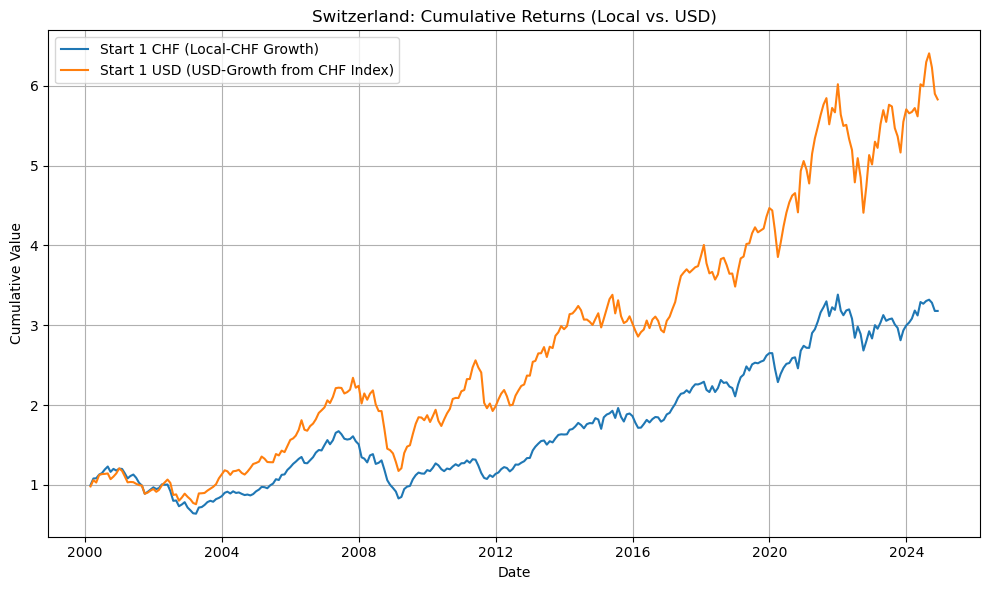

In [67]:
sw_df = processed_data["switzerland"]

cum_local = (1 + sw_df["return"]).cumprod()     # e.g. start with 1 CHF
cum_usd   = (1 + sw_df["usd_return"]).cumprod()  # start with 1 USD

plt.figure(figsize=(10, 6))
plt.plot(cum_local.index, cum_local, label="Start 1 CHF (Local‐CHF Growth)")
plt.plot(cum_usd.index,   cum_usd,   label="Start 1 USD (USD‐Growth from CHF Index)")

plt.title("Switzerland: Cumulative Returns (Local vs. USD)")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Swiss-franc tended to appreciate (or at least hold its value) against the USD, especially through crisis periods (2001 dot-com bust, 2008, 2011, 2015, COVID, etc.).  That currency appreciation amplifies the local equity return when measured in USD.

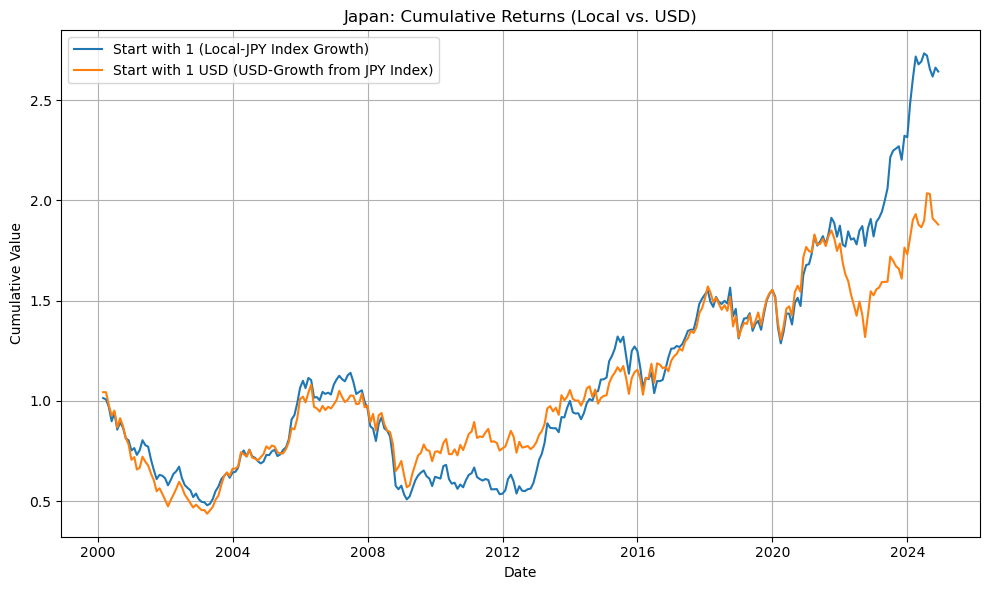

In [68]:
jp_df = processed_data["japan"].copy()

cum_local_jp = (1 + jp_df["return"]).cumprod()      # start with 1 (in local‐JPY‐index terms)
cum_usd_jp   = (1 + jp_df["usd_return"]).cumprod()   # start with 1 USD

plt.figure(figsize=(10, 6))
plt.plot(cum_local_jp.index, cum_local_jp, label="Start with 1 (Local‐JPY Index Growth)")
plt.plot(cum_usd_jp.index,   cum_usd_jp,   label="Start with 1 USD (USD‐Growth from JPY Index)")

plt.title("Japan: Cumulative Returns (Local vs. USD)")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Japanese yen (JPY) has depreciated versus the USD over this period.  A weakening yen erodes your JPY-returns once you translate back to dollars.

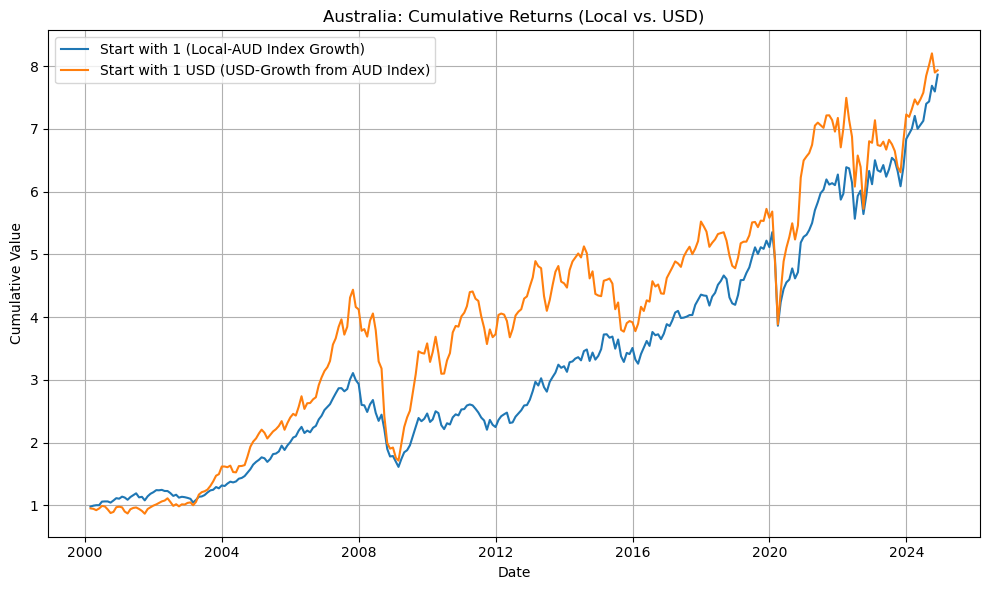

In [69]:
aus_df = processed_data["australia"].copy()

cum_local_aus = (1 + aus_df["return"]).cumprod()      # start with 1 (in local‐JPY‐index terms)
cum_usd_aus   = (1 + aus_df["usd_return"]).cumprod()   # start with 1 USD

plt.figure(figsize=(10, 6))
plt.plot(cum_local_aus.index, cum_local_aus, label="Start with 1 (Local‐AUD Index Growth)")
plt.plot(cum_usd_aus.index,   cum_usd_aus,   label="Start with 1 USD (USD‐Growth from AUD Index)")

plt.title("Australia: Cumulative Returns (Local vs. USD)")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3.b. Currency-hedged index return

Initializing correct data, start with interbank rates

In [70]:
#    Read each 3-month interbank CSV, parse the "observation_date" column as DatetimeIndex,
#    select only the rate column, and rename it to the correct ISO code.

aus_ib = pd.read_csv(
    "data/AUSTRALIA_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
aus_ib = aus_ib.iloc[:, [0]].rename(columns={aus_ib.columns[0]: "AUD"})
aus_ib["AUD"] = aus_ib["AUD"] / 100


eur_ib = pd.read_csv(
    "data/EUROPE_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
eur_ib = eur_ib.iloc[:, [0]].rename(columns={eur_ib.columns[0]: "EUR"})
eur_ib["EUR"] = eur_ib["EUR"] / 100


gbp_ib = pd.read_csv(
    "data/GREATBRITAIN_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
gbp_ib = gbp_ib.iloc[:, [0]].rename(columns={gbp_ib.columns[0]: "GBP"})
gbp_ib["GBP"] = gbp_ib["GBP"] / 100


jpy_ib = pd.read_csv(
    "data/JAPAN_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
jpy_ib = jpy_ib.iloc[:, [0]].rename(columns={jpy_ib.columns[0]: "JPY"})
jpy_ib["JPY"] = jpy_ib["JPY"] / 100


chf_ib = pd.read_csv(
    "data/SWITZERLAND_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
chf_ib = chf_ib.iloc[:, [0]].rename(columns={chf_ib.columns[0]: "CHF"})
chf_ib["CHF"] = chf_ib["CHF"] / 100

usd_ib = pd.read_csv(
    "data/USA_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
usd_ib = usd_ib.iloc[:, [0]].rename(columns={usd_ib.columns[0]: "USD"})
usd_ib["USD"] = usd_ib["USD"] / 100

# Combine all six DataFrames side-by-side (inner join on the common dates)
ibexr = pd.concat(
    [usd_ib, eur_ib, jpy_ib, gbp_ib, chf_ib, aus_ib],
    axis=1,
    join="inner"
)

# Ensure the index is sorted and is exactly at month-end
ibexr.index = pd.to_datetime(ibexr.index)
ibexr = ibexr.sort_index()

ibexr = ibexr.resample("M").last().dropna(how="all")

print(ibexr.head())


                     USD       EUR     JPY       GBP       CHF     AUD
observation_date                                                      
2002-04-30        0.0187  0.034069  0.0010  0.041732  0.014606  0.0459
2002-05-31        0.0182  0.034671  0.0008  0.041537  0.011635  0.0484
2002-06-30        0.0181  0.034640  0.0009  0.041776  0.011496  0.0507
2002-07-31        0.0179  0.034100  0.0009  0.040605  0.010031  0.0498
2002-08-31        0.0173  0.033519  0.0007  0.039865  0.006683  0.0496


/var/folders/8v/10cr8tb10sj9jl40zffsd8900000gn/T/ipykernel_25531/2980223554.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ibexr = ibexr.resample("M").last().dropna(how="all")


In [71]:
iso_map = {
    "japan":         "JPN",
    "australia":     "AUS",
    "germany":       "DEU",
    "france":        "FRA",
    "switzerland":   "CHE",
    "unitedkingdom": "GBR"
}

idx_returns = pd.DataFrame({
    iso_map[country]: df["usd_return"]
    for country, df in processed_data.items()
})
idx_returns.index = pd.to_datetime(idx_returns.index)
idx_returns = idx_returns.sort_index()

cexr = pd.DataFrame({
    "JPY": processed_data["japan"]["fx"],
    "CHF": processed_data["switzerland"]["fx"],
    "AUD": processed_data["australia"]["fx"],
    "EUR": processed_data["germany"]["fx"],
    "GBP": processed_data["unitedkingdom"]["fx"]
})
cexr.index = pd.to_datetime(cexr.index)
cexr = cexr.sort_index()

In [72]:
cexr.head()

,JPY,CHF,AUD,EUR,GBP
2000-02-29,0.009407,0.601106,0.6094,0.9643,1.5799
2000-03-31,0.009467,0.600348,0.5960,0.9449,1.5823
2000-04-30,0.009232,0.581734,0.5784,0.9059,1.5090
2000-05-31,0.009423,0.609013,0.5949,0.9505,1.5092
2000-06-30,0.009241,0.605364,0.5870,0.9386,1.5076


In [73]:
idx_returns.head()

,JPN,AUS,DEU,FRA,CHE,GBR
2000-02-29,0.043347,-0.048888,0.107163,0.069145,-0.019227,-0.002400
2000-03-31,-0.000149,-0.007589,-0.021565,-0.002772,0.080631,0.066701
2000-04-30,-0.060554,-0.022366,-0.084513,-0.035133,-0.028527,-0.064905
2000-05-31,-0.055021,0.028952,0.021039,0.064185,0.091633,0.009326
2000-06-30,0.027203,0.042741,-0.045288,-0.009468,0.009914,0.008821


Defining currency-hedging function

In [74]:
def compute_hedged_returns(idx_returns: pd.DataFrame,
                           cexr: pd.DataFrame,
                           ibexr: pd.DataFrame
                          ) -> pd.DataFrame:
    """
    Compute *currency‐hedged* USD returns for each index.

    - idx_returns: DataFrame, columns = ["AUS","CHE","DEU","FRA","GBR","JPN"],
      each column is the *unhedged USD return* of that country’s stock index,
      indexed by month‐end dates.

    - cexr:       DataFrame, columns = ["AUD","CHF","EUR","GBP","JPY"],
      each column is the USD/foreign‐currency spot rate at month‐end.

    - ibexr:      DataFrame, columns = ["USD","EUR","JPY","GBP","CHF","AUD"],
      each column is the 3-month (annualized) interbank rate *in decimals*,
      indexed by month‐end.

    Returns a DataFrame “hedged” with columns = ["AUS","CHE","DEU","FRA","GBR","JPN"],
    giving the *currency‐hedged USD return* (each month) for each country’s index.
    """

    # 1) copy & sort all three on their date‐index
    idx       = idx_returns.copy().sort_index()
    fx        = cexr.copy().sort_index()
    rf_3mo    = ibexr.copy().sort_index()

    # 2) make 1-month effective rates
    rf_1mo = (1 + rf_3mo).pow(1/3) - 1

    # 3) split US vs. local
    r_us     = rf_1mo["USD"]               # Series of shape (N,)
    rf_local = rf_1mo.drop(columns="USD")  # DataFrame shape (N,5)

    # 4) intersect dates so everything lines up
    common_idx = idx.index \
                  .intersection(fx.index) \
                  .intersection(rf_local.index) \
                  .intersection(r_us.index)

    idx       = idx.loc[common_idx]
    fx        = fx.loc[common_idx]
    rf_local  = rf_local.loc[common_idx]
    r_us      = r_us.loc[common_idx]

    # 5) **explicitly reorder** rf_local to match fx.columns
    #    fx.columns == ["AUD","CHF","EUR","GBP","JPY"]
    rf_local = rf_local[fx.columns]

    # 6) compute spot‐ratio S_{t+1}/S_t
    S_t    = fx
    S_tp1  = fx.shift(-1)

    # 7) compute the “excess” (currency‐carry) X_t^ccy = (S_{t+1}/S_t)*(1 + r_local) – (1 + r_us)
    X = (S_tp1.div(S_t)                       # label‐wise division
            .mul(1 + rf_local)               # elementwise multiply by local rate
            .subtract(1 + r_us, axis=0)      # subtract US rate (broadcast by index)
        )

    # 8) pick off the right column of X for each index
    country2ccy = {
        "AUS": "AUD",
        "CHE": "CHF",
        "DEU": "EUR",
        "FRA": "EUR",
        "GBR": "GBP",
        "JPN": "JPY"
    }
    # for each idx‐column, find its currency
    pick = [country2ccy[c] for c in idx.columns]
    X_sel = X[pick].copy()
    X_sel.columns = idx.columns   # rename back to index‐codes

    # 9) shift X_sel ↓1 so that X_sel.loc[t] = X_t lines up with idx.loc[t]
    X_sel = X_sel.shift(1)

    # 10) final overlap & subtract
    common_final = idx.index.intersection(X_sel.index)
    hedged = idx.loc[common_final] - X_sel.loc[common_final]
    return hedged.dropna()

In [75]:
hedged_returns = compute_hedged_returns(idx_returns, cexr, ibexr)
hedged_returns["CHE"].tail()

2024-07-31    0.023461
2024-08-31    0.018153
2024-09-30    0.001988
2024-10-31   -0.017982
2024-11-30    0.012263
Name: CHE, dtype: float64

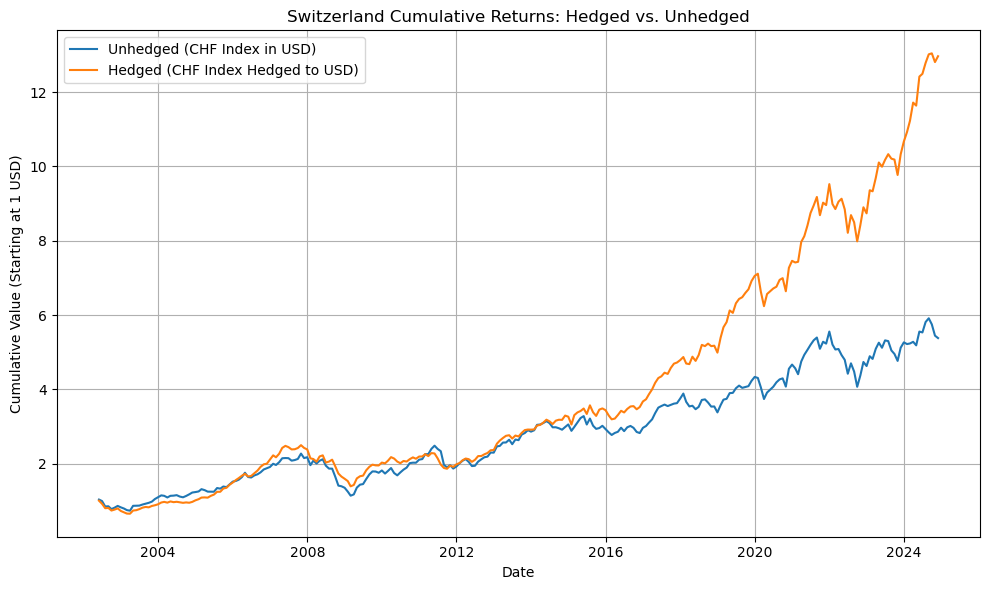

In [76]:
sw_unhedged = processed_data["switzerland"]["usd_return"].copy()
sw_hedged   = hedged_returns["CHE"].copy()

# Make sure they share the same dates (intersection)
common_dates = sw_unhedged.index.intersection(sw_hedged.index)
sw_unhedged = sw_unhedged.loc[common_dates]
sw_hedged   = sw_hedged.loc[common_dates]

# Compute cumulative growth starting from 1 USD
cum_unhedged = (1 + sw_unhedged).cumprod()
cum_hedged   = (1 + sw_hedged).cumprod()

# Plot both on the same chart
plt.figure(figsize=(10, 6))
plt.plot(cum_unhedged.index, cum_unhedged, label="Unhedged (CHF Index in USD)")
plt.plot(cum_hedged.index,   cum_hedged,   label="Hedged (CHF Index Hedged to USD)")

plt.title("Switzerland Cumulative Returns: Hedged vs. Unhedged")
plt.xlabel("Date")
plt.ylabel("Cumulative Value (Starting at 1 USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Because Swiss 3‐month interest rates have been consistently below U.S. 3‐month rates over much of the sample, the act of hedging (i.e. borrowing USD at a higher rate and investing in CHF at a lower rate) creates a net positive carry that more than offsets the loss of the “CHF→USD appreciation” tailwind.

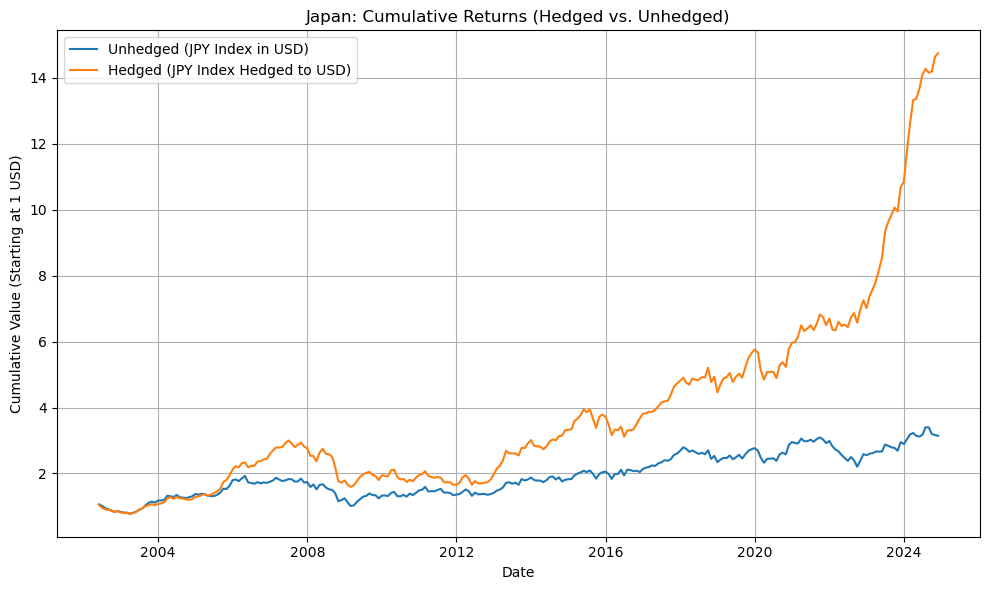

In [77]:
jp_unhedged = processed_data["japan"]["usd_return"].copy()
jp_hedged   = hedged_returns["JPN"].copy()

# Align their dates (take the intersection)
common_dates = jp_unhedged.index.intersection(jp_hedged.index)
jp_unhedged = jp_unhedged.loc[common_dates]
jp_hedged   = jp_hedged.loc[common_dates]

# Compute cumulative growth starting from 1.0 USD
cum_unhedged_jp = (1 + jp_unhedged).cumprod()
cum_hedged_jp   = (1 + jp_hedged).cumprod()

# Plot both on the same chart
plt.figure(figsize=(10, 6))
plt.plot(cum_unhedged_jp.index, cum_unhedged_jp, label="Unhedged (JPY Index in USD)")
plt.plot(cum_hedged_jp.index,   cum_hedged_jp,   label="Hedged (JPY Index Hedged to USD)")

plt.title("Japan: Cumulative Returns (Hedged vs. Unhedged)")
plt.xlabel("Date")
plt.ylabel("Cumulative Value (Starting at 1 USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

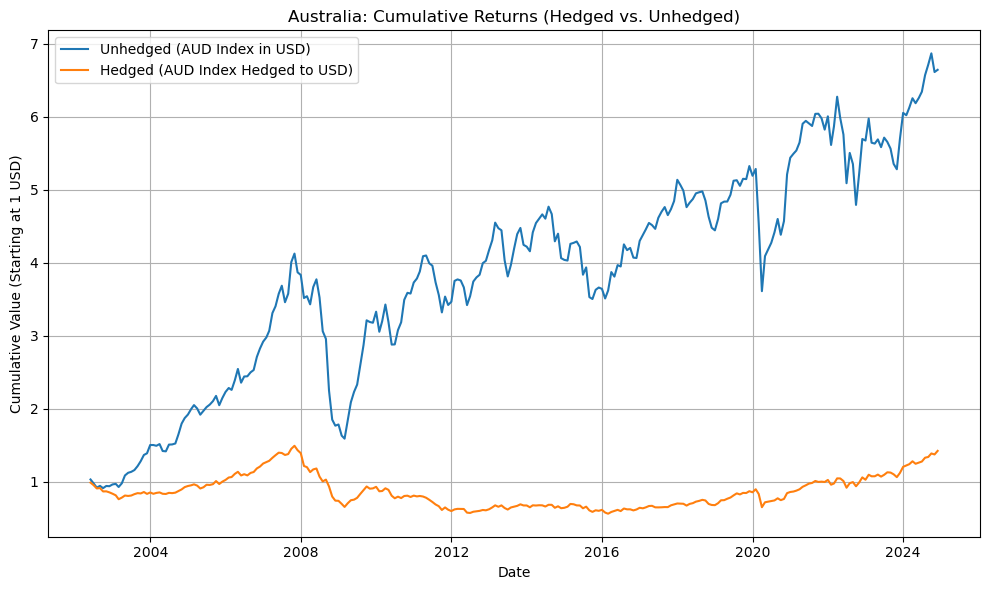

In [78]:
aus_unhedged = processed_data["australia"]["usd_return"].copy()
aus_hedged   = hedged_returns["AUS"].copy()

# Align their dates (take the intersection)
common_dates = aus_unhedged.index.intersection(aus_hedged.index)
aus_unhedged = aus_unhedged.loc[common_dates]
aus_hedged   = aus_hedged.loc[common_dates]

# Compute cumulative growth starting from 1.0 USD
cum_unhedged_aus = (1 + aus_unhedged).cumprod()
cum_hedged_aus   = (1 + aus_hedged).cumprod()

# Plot both on the same chart
plt.figure(figsize=(10, 6))
plt.plot(cum_unhedged_aus.index, cum_unhedged_aus, label="Unhedged (AUD Index in USD)")
plt.plot(cum_hedged_aus.index,   cum_hedged_aus,   label="Hedged (AUD Index Hedged to USD)")

plt.title("Australia: Cumulative Returns (Hedged vs. Unhedged)")
plt.xlabel("Date")
plt.ylabel("Cumulative Value (Starting at 1 USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3.c. International Diversification

In [79]:
def compute_strategy(idx_returns_df, weights_df):
    """
    Compute portfolio returns given index returns and a time‐series of weights.
    :param idx_returns_df: DataFrame of index returns (columns = country codes, index = month‐end dates)
    :param weights_df:     DataFrame of the same shape, containing the weight in each index at each date
    :return:               Series of portfolio returns (indexed by date)
    """
    # We shift weights forward by one month so that today's weights apply to next month's returns
    applied_weights = weights_df.shift(1).fillna(0)
    # Portfolio return = sum over (return_i * weight_i) across all indices i
    portfolio_returns = (idx_returns_df * applied_weights).sum(axis=1)
    return portfolio_returns

# Equal Weights

In [80]:
# “equal‐weight” schedule for all indices in hedged_returns
n_indices = hedged_returns.shape[1]               
base_weights = [1 / n_indices] * n_indices        # [1/6, 1/6, …, 1/6]

weight_array = np.tile(base_weights, (hedged_returns.shape[0], 1))

# no allocation until we have 60 months of history
weight_array[:60, :] = 0

weights = pd.DataFrame(
    weight_array,
    index=hedged_returns.index,
    columns=hedged_returns.columns
)

weights = weights.div(weights.sum(axis=1), axis=0).fillna(0)


#     Using unhedged USD index returns (idx_returns)
equal_weights_returns = compute_strategy(idx_returns, weights)

#     Using currency‐hedged index returns (hedged_returns)
equal_weights_hedged_returns = compute_strategy(hedged_returns, weights)


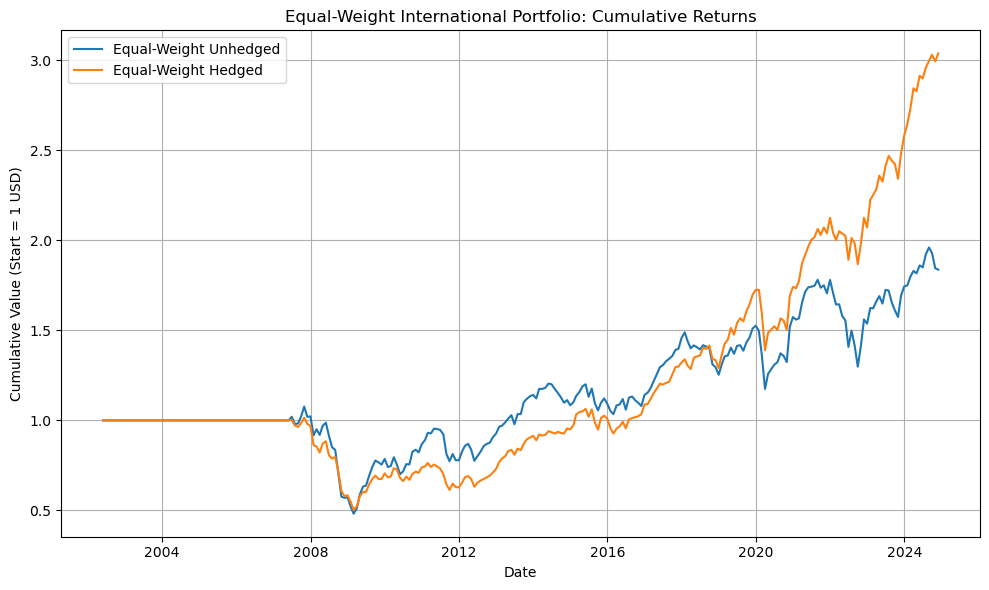

In [81]:
cum_unhedged_eq = (1 + equal_weights_returns).cumprod()
cum_hedged_eq   = (1 + equal_weights_hedged_returns).cumprod()

common_dates_eq = cum_unhedged_eq.index.intersection(cum_hedged_eq.index)
cum_unhedged_eq = cum_unhedged_eq.loc[common_dates_eq]
cum_hedged_eq   = cum_hedged_eq.loc[common_dates_eq]

plt.figure(figsize=(10, 6))
plt.plot(cum_unhedged_eq.index, cum_unhedged_eq, label="Equal‐Weight Unhedged")
plt.plot(cum_hedged_eq.index,   cum_hedged_eq,   label="Equal‐Weight Hedged")

plt.title("Equal‐Weight International Portfolio: Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Value (Start = 1 USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Risk-Parity

In [82]:
rolling_window = 60

#  Compute rolling volatilities (raw, one‐period σ) for each index in the UNHEDGED case:
rolling_vol_unhedged = idx_returns.rolling(window=rolling_window).std()

rolling_vol_unhedged_filled = rolling_vol_unhedged.fillna(1e6)

#  Raw “inverse‐vol” scores:
inv_vol_unhedged = 1.0 / rolling_vol_unhedged_filled

# Normalize :
raw_weights_unhedged = inv_vol_unhedged.div(inv_vol_unhedged.sum(axis=1), axis=0)

# For the first 60 months (where we didn’t really have a valid rolling vol), force weights to zero:
raw_weights_unhedged.iloc[:rolling_window, :] = 0.0

risk_parity_unhedged = compute_strategy(idx_returns, raw_weights_unhedged)

# ────────────────────────────────────────────────────────────────────────────

#  HEDGED case:
rolling_vol_hedged = hedged_returns.rolling(window=rolling_window).std()
rolling_vol_hedged_filled = rolling_vol_hedged.fillna(1e6)
inv_vol_hedged = 1.0 / rolling_vol_hedged_filled
raw_weights_hedged = inv_vol_hedged.div(inv_vol_hedged.sum(axis=1), axis=0)
raw_weights_hedged.iloc[:rolling_window, :] = 0.0

risk_parity_hedged = compute_strategy(hedged_returns, raw_weights_hedged)


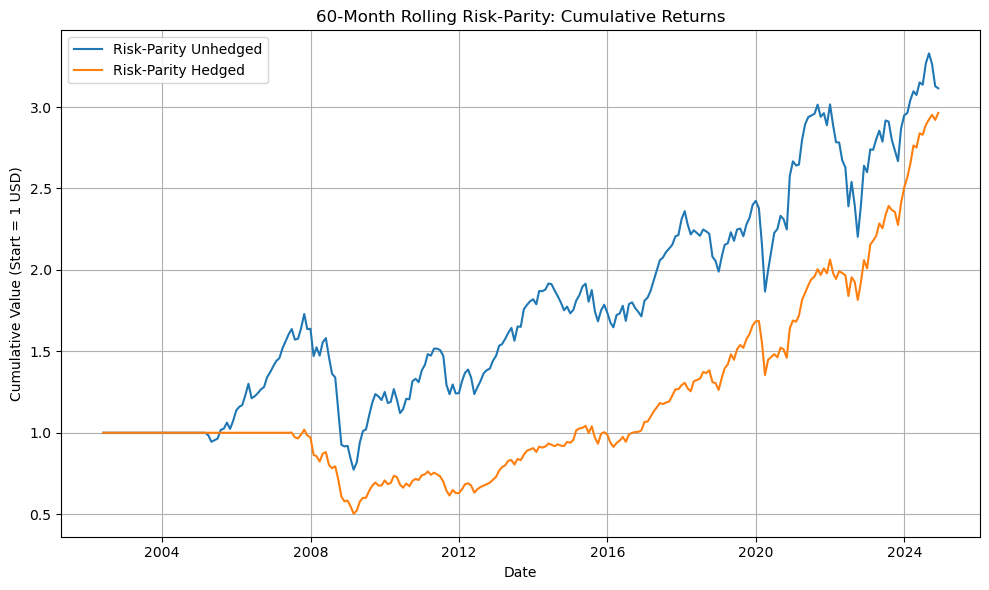

In [83]:
cum_rp_unhedged = (1 + risk_parity_unhedged).cumprod()
cum_rp_hedged   = (1 + risk_parity_hedged).cumprod()

common = cum_rp_unhedged.index.intersection(cum_rp_hedged.index)
cum_rp_unhedged = cum_rp_unhedged.loc[common]
cum_rp_hedged   = cum_rp_hedged.loc[common]

plt.figure(figsize=(10, 6))
plt.plot(cum_rp_unhedged.index, cum_rp_unhedged, label="Risk-Parity Unhedged")
plt.plot(cum_rp_hedged.index,   cum_rp_hedged,   label="Risk-Parity Hedged")
plt.title("60-Month Rolling Risk-Parity: Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Value (Start = 1 USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mean-Variance

In [84]:
def mv_optimization(cov_matrix: np.ndarray,
                    mean_returns: np.ndarray,
                    rf: float,
                    gamma: float = 1.0
                   ) -> np.ndarray:
    """
    Solve for weights w = [w1,...,wn] that maximize:
        (mean_returns - rf)ᵀ w - 0.5 * gamma * wᵀ cov_matrix w
    subject to:
        sum(w) = 1
        0 ≤ w_i ≤ 1  for all i

    :param cov_matrix:   (n×n) covariance matrix of asset returns
    :param mean_returns: length‐n array of expected returns (monthly)
    :param rf:           scalar risk‐free rate for the same period (monthly)
    :param gamma:        risk‐aversion parameter (higher → more conservative, default=1)
    :return:             length‐n array of weights summing to 1 (or close to 1)
    """
    n = len(mean_returns)

    # The objective is maximization of:
    #     (mean_returns - rf)ᵀ w  -  0.5 * gamma * wᵀ cov_matrix w
    # we minimize the negative of that.
    def objective(w):
        # (mean - rf)ᵀ w
        excess_return = np.dot(mean_returns - rf, w)
        # 0.5 * gamma * wᵀ cov w
        penalty = 0.5 * gamma * np.dot(w, cov_matrix.dot(w))
        return - (excess_return - penalty)

    # Equality constraint: sum(w) = 1
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1.0}
    ]

    # Bound each weight to [0, 1]
    bounds = [(0.0, 1.0) for _ in range(n)]

    # Start at equal weights
    w0 = np.ones(n) / n

    result = minimize(
        objective,
        x0=w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )

    if not result.success:
        # In case the optimizer fails, fall back to equal weights
        print("Optimization failed:")
        return np.ones(n) / n

    return result.x


In [85]:
def compute_optimal_weights(returns_df: pd.DataFrame,
                            ibexr_df: pd.DataFrame,
                            rolling_window: int = 60
                           ) -> pd.DataFrame:
    """
    For each month t, uses the prior `rolling_window` months of returns to estimate:
      • mean_returns (length‐n)
      • cov_matrix (n×n)
      • rf_t         (scalar, the USD one‐month rate for month t)
    Then solves a mean‐variance problem w* = argmax_w { (mean - rf)ᵀ w - 0.5 γ wᵀ Σ w }
    with constraints sum(w)=1 and 0 ≤ w_i ≤ 1.  We set γ=1 here.

    For the first `rolling_window` months, we have insufficient data → weights = 0.

    Returns a DataFrame `opt_weights` of shape (T × n), where T = len(returns_df),
    n = number of columns (countries).  Each row t is the weight vector chosen
    at time t (used to invest *in the next month*).
    """
    # Number of countries (e.g. 6)
    n_countries = returns_df.shape[1]
    dates = returns_df.index

    # 2a) We need the USD risk‐free rate *for each month t*.
    #     Our `ibexr_df` has a column "USD" (the 3‐month annualized rate),
    #     but for mean‐variance we can simply plug that in as the “rf” for each month.
    #     (If you wanted to convert it to a one‐month continuously compounded rate,
    #     you could—but here we will use it directly as `rf`.)
    rf_all = ibexr_df["USD"].reindex(dates).fillna(method="ffill")  # align to same index

    # 2b) Prepare a container for the weights
    all_weights = []

    # 2c) For the first `rolling_window` months (0‒59), we cannot compute Σ or μ,
    #     so we just append a zero‐vector of length n.
    zero_weights = np.zeros(n_countries)
    for _ in range(rolling_window):
        all_weights.append(zero_weights)

    # 2d) Starting at t = rolling_window, compute mean & cov on the previous 60 months
    for t in range(rolling_window, len(dates)):
        # Window of past 60 months: from (t-rolling_window) up to (t-1), inclusive.
        # That is, at t = 60, window = returns_df.iloc[0:60]  (the first 60 rows).
        window = returns_df.iloc[t - rolling_window : t]

        #  • mean_returns: length‐n numpy array of column means over that window
        mean_vec = window.mean().values

        #  • cov_matrix: n×n numpy array of covariances over that window
        cov_mat = window.cov().values

        #  • rf_t: the USD rate at time t (the same index as returns_df)
        rf_t = rf_all.iloc[t]

        #  2d‐iv) Solve the mean‐variance quadratic program
        w_t = mv_optimization(cov_mat, mean_vec, rf_t, gamma=1.0)

        #  2d‐v) As a sanity check, re‐normalize w_t in case numerical error caused sum(w) ≠ 1
        if np.sum(w_t) != 0:
            w_t = w_t / np.sum(w_t)

        all_weights.append(w_t)

    # 2e) Convert the list of weight‐arrays into a DataFrame
    opt_weights = pd.DataFrame(
        np.vstack(all_weights),
        index=dates,
        columns=returns_df.columns
    )

    return opt_weights


In [86]:
# Unhedged USD index returns
opt_weights_unhedged = compute_optimal_weights(idx_returns, ibexr, rolling_window=60)
opt_returns_unhedged = compute_strategy(idx_returns, opt_weights_unhedged)

# Currency‐hedged USD returns
opt_weights_hedged = compute_optimal_weights(hedged_returns, ibexr, rolling_window=60)
opt_returns_hedged = compute_strategy(hedged_returns, opt_weights_hedged)


/var/folders/8v/10cr8tb10sj9jl40zffsd8900000gn/T/ipykernel_25531/329813972.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_all = ibexr_df["USD"].reindex(dates).fillna(method="ffill")  # align to same index
/var/folders/8v/10cr8tb10sj9jl40zffsd8900000gn/T/ipykernel_25531/329813972.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_all = ibexr_df["USD"].reindex(dates).fillna(method="ffill")  # align to same index


# Metrics

In [87]:
def annualized_metrics(monthly_ret: pd.Series):
    """
    Given a Series of monthly returns (e.g. 0.01 = +1%), compute:
      - annualized mean return
      - annualized volatility
      - Sharpe ratio (assuming zero RF)

    Returns a tuple: (mean_ann, vol_ann, sharpe_ann)
    """
    # Drop NaNs just in case
    r = monthly_ret.dropna()

    # 1) Compute average monthly and monthly std
    mean_m = r.mean()
    std_m  = r.std(ddof=0)  # population‐style; you can use ddof=1 if preferred

    # 2) Annualize
    mean_ann = mean_m * 12
    vol_ann  = std_m * np.sqrt(12)

    # 3) Sharpe
    sharpe_ann = mean_ann / vol_ann if vol_ann != 0 else np.nan

    return mean_ann, vol_ann, sharpe_ann

In [88]:
common_index = (
    equal_weights_returns.index
    .intersection(equal_weights_hedged_returns.index)
    .intersection(risk_parity_unhedged.index)
    .intersection(risk_parity_hedged.index)
)

ew_un = equal_weights_returns.loc[common_index]
ew_hd = equal_weights_hedged_returns.loc[common_index]
rp_un = risk_parity_unhedged.loc[common_index]
rp_hd = risk_parity_hedged.loc[common_index]

ew_un_stats = annualized_metrics(ew_un)
ew_hd_stats = annualized_metrics(ew_hd)
rp_un_stats = annualized_metrics(rp_un)
rp_hd_stats = annualized_metrics(rp_hd)

results = pd.DataFrame(
    {
        "Equal‐Weight Unhedged":   ew_un_stats,
        "Equal‐Weight Hedged":     ew_hd_stats,
        "Risk‐Parity Unhedged":    rp_un_stats,
        "Risk‐Parity Hedged":      rp_hd_stats
    },
    index=["Mean (ann)", "Vol (ann)", "Sharpe (ann)"]
)

results = results.T

print("\nAnnualized Metrics for Each Strategy:\n")
display(results)


Annualized Metrics for Each Strategy:



,Mean (ann),Vol (ann),Sharpe (ann)
Equal‐Weight Unhedged,0.037027,0.139917,0.264637
Equal‐Weight Hedged,0.056633,0.118634,0.477378
Risk‐Parity Unhedged,0.057915,0.143402,0.403865
Risk‐Parity Hedged,0.055405,0.117556,0.471309


In [89]:
common_index = (
    equal_weights_returns.index
    .intersection(equal_weights_hedged_returns.index)
    .intersection(risk_parity_unhedged.index)
    .intersection(risk_parity_hedged.index)
    .intersection(opt_returns_unhedged.index)   # include MV unhedged
    .intersection(opt_returns_hedged.index)     # include MV hedged
)

# 2) Subset all five return series to that same common index
ew_un = equal_weights_returns.loc[common_index]
ew_hd = equal_weights_hedged_returns.loc[common_index]
rp_un = risk_parity_unhedged.loc[common_index]
rp_hd = risk_parity_hedged.loc[common_index]
mv_un = opt_returns_unhedged.loc[common_index]
mv_hd = opt_returns_hedged.loc[common_index]

# 3) Compute annualized metrics for each of the five strategies
ew_un_stats = annualized_metrics(ew_un)
ew_hd_stats = annualized_metrics(ew_hd)
rp_un_stats = annualized_metrics(rp_un)
rp_hd_stats = annualized_metrics(rp_hd)
mv_un_stats = annualized_metrics(mv_un)
mv_hd_stats = annualized_metrics(mv_hd)

# 4) Build a DataFrame that now includes the Mean‐Variance results
results = pd.DataFrame(
    {
        "Equal‐Weight Unhedged":     ew_un_stats,
        "Equal‐Weight Hedged":       ew_hd_stats,
        "Risk‐Parity Unhedged":      rp_un_stats,
        "Risk‐Parity Hedged":        rp_hd_stats,
        "Mean‐Variance Unhedged":    mv_un_stats,
        "Mean‐Variance Hedged":      mv_hd_stats
    },
    index=["Mean (ann)", "Vol (ann)", "Sharpe (ann)"]
)

# 5) Transpose so that each row is one strategy, and display
results = results.T

print("\nAnnualized Metrics for Each Strategy (including Mean‐Variance):\n")
display(results)



Annualized Metrics for Each Strategy (including Mean‐Variance):



,Mean (ann),Vol (ann),Sharpe (ann)
Equal‐Weight Unhedged,0.037027,0.139917,0.264637
Equal‐Weight Hedged,0.056633,0.118634,0.477378
Risk‐Parity Unhedged,0.057915,0.143402,0.403865
Risk‐Parity Hedged,0.055405,0.117556,0.471309
Mean‐Variance Unhedged,0.057498,0.164266,0.350028
Mean‐Variance Hedged,0.065311,0.123799,0.527557


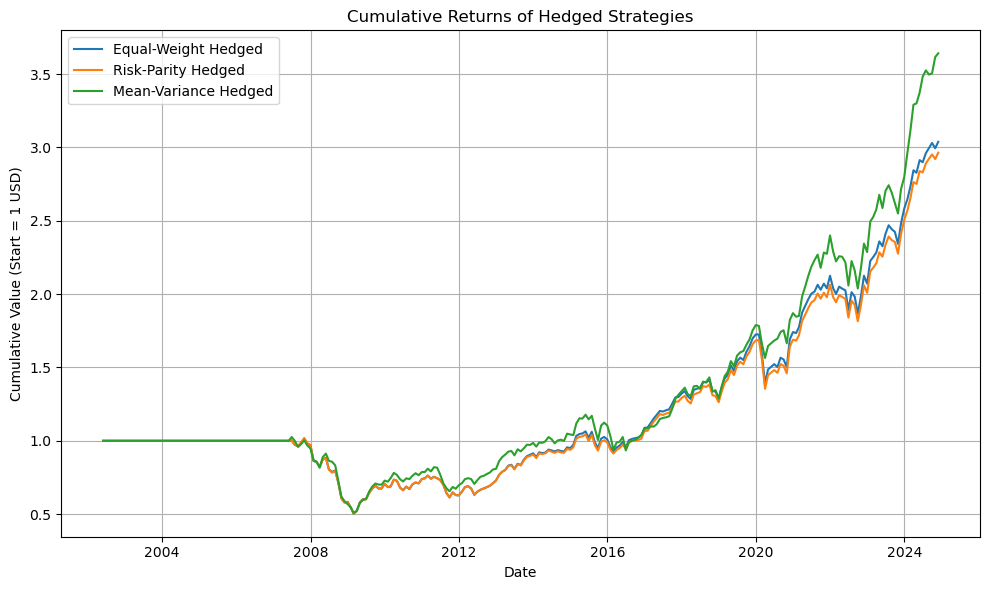

In [90]:
series_ew_hd = equal_weights_hedged_returns.copy()
series_rp_hd = risk_parity_hedged.copy()
series_mv_hd = opt_returns_hedged.copy()

common_dates = (
    series_ew_hd.index
    .intersection(series_rp_hd.index)
    .intersection(series_mv_hd.index)
)
series_ew_hd = series_ew_hd.loc[common_dates]
series_rp_hd = series_rp_hd.loc[common_dates]
series_mv_hd = series_mv_hd.loc[common_dates]

cum_ew_hd = (1 + series_ew_hd).cumprod()
cum_rp_hd = (1 + series_rp_hd).cumprod()
cum_mv_hd = (1 + series_mv_hd).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cum_ew_hd.index, cum_ew_hd, label="Equal‐Weight Hedged")
plt.plot(cum_rp_hd.index, cum_rp_hd, label="Risk‐Parity Hedged")
plt.plot(cum_mv_hd.index, cum_mv_hd, label="Mean‐Variance Hedged")

plt.title("Cumulative Returns of Hedged Strategies")
plt.xlabel("Date")
plt.ylabel("Cumulative Value (Start = 1 USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
# Save the unhedged USD index returns and the currency-hedged index returns to CSV files

# 1) idx_returns: DataFrame of unhedged USD returns for each country (columns = ["AUS","CHE","DEU","FRA","GBR","JPN"])
idx_returns.to_csv("results/DIV/idx_returns_usd.csv", index=True, header=True)

# 2) hedged_returns: DataFrame of currency-hedged USD returns for each country (same columns)
hedged_returns.to_csv("results/DIV/hedged_idx_returns_usd.csv", index=True, header=True)

# Wrapping up

In [92]:
# 1) Country‐specific cumulative returns, unhedged & hedged
cum_country_unhedged = (1 + idx_returns).cumprod()
cum_country_hedged   = (1 + hedged_returns).cumprod()

# 2) International strategies cumulative returns
cum_eq_unhedged = (1 + equal_weights_returns).cumprod().rename("EQ_UNHEDGED")
cum_eq_hedged   = (1 + equal_weights_hedged_returns).cumprod().rename("EQ_HEDGED")

cum_rp_unhedged = (1 + risk_parity_unhedged).cumprod().rename("RP_UNHEDGED")
cum_rp_hedged   = (1 + risk_parity_hedged).cumprod().rename("RP_HEDGED")

cum_mv_unhedged = (1 + opt_returns_unhedged).cumprod().rename("MV_UNHEDGED")
cum_mv_hedged   = (1 + opt_returns_hedged).cumprod().rename("MV_HEDGED")

# 3) Build a single DataFrame
big_df = pd.DataFrame(index=idx_returns.index)

# Country‐specific columns:
for country in idx_returns.columns:
    big_df[f"{country}_UNHEDGED"] = cum_country_unhedged[country]
    big_df[f"{country}_HEDGED"]   = cum_country_hedged[country]

# Strategy columns:
big_df = big_df.join([
    cum_eq_unhedged,
    cum_eq_hedged,
    cum_rp_unhedged,
    cum_rp_hedged,
    cum_mv_unhedged,
    cum_mv_hedged
], how="outer")



In [93]:
# 4) Save the combined cumulative returns
big_df.to_csv("results/DIV/all_cumulative_returns.csv", index=True)

# 5) Save the “Mean‐Variance Hedged” returns as DIV_returns.csv
#    (This was the best Sharpe in the internationally diversified hedged set.)
opt_returns_hedged.to_csv("results/DIV/DIV_returns.csv", index=True, header=True)